# Notebook examples for Chapter 7

In [1]:
%matplotlib inline

## Probabilistic label relaxation

Training with NNet(Congrad)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 2.32325315475
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.6162109375
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif


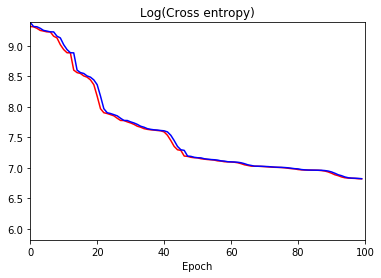

test results written to: imagery/AST_20070501_pca_NNet(Congrad).tst
done


In [2]:
run scripts/classify -a 4 -p [1,2,3,4] -L [10,10] -P imagery/AST_20070501_pca.tif imagery/train.shp

In [2]:
run scripts/plr imagery/AST_20070501_pca_classprobs.tif

       PLR
infile:  imagery/AST_20070501_pca_classprobs.tif
iterations:  3
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
result written to: imagery/AST_20070501_pca_classprobs_plr.tif
elapsed time: 99.3968970776
--done------------------------


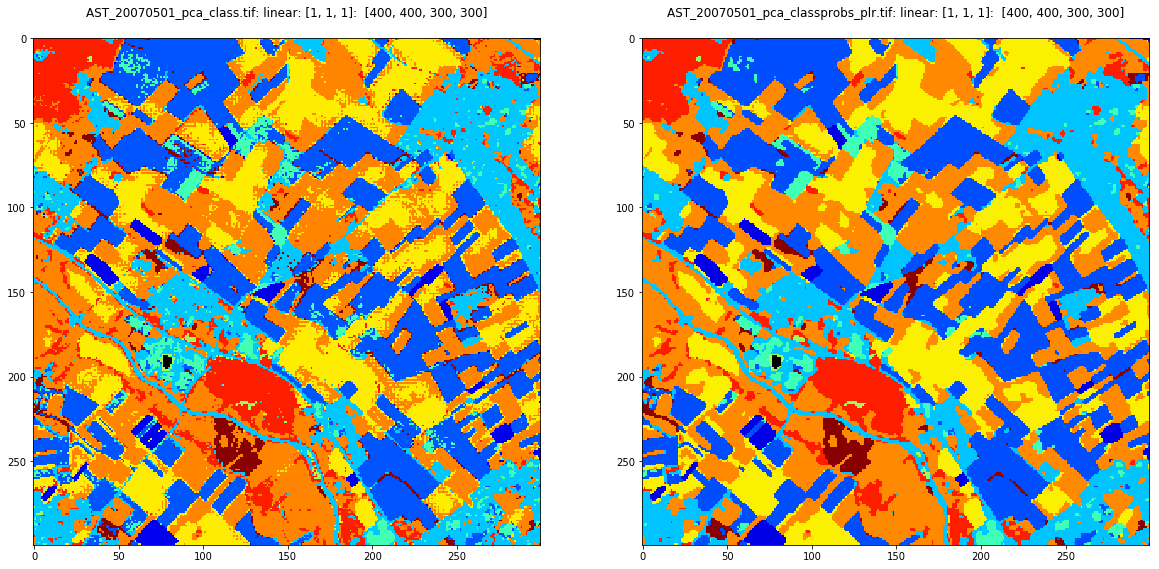

In [5]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c -d [400,400,300,300] \
-F imagery/AST_20070501_pca_classprobs_plr.tif -C -D [400,400,300,300] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_1.eps'

## Accuracy assessment

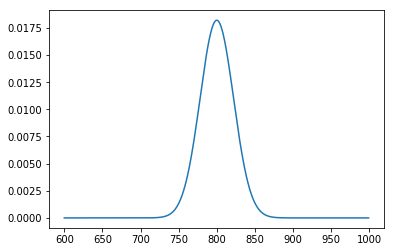

In [6]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

theta = 0.4
n = 2000
x = np.arange(600, 1000)
# pmf = probability mass function
plt.plot(x, binom.pmf(x, n, theta))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_2.eps')

### Accuracy assessment on the GEE

In [3]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')

# sample the image with the polygons to a feature  
# collection, rename the class id columns from strings to 
# integers and add a column of random numbers in [0,1]
trainTestData = image.sampleRegions(collection=table,
                                    properties=['CLASS_ID'],
                                    scale=15) \
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID') \
    .randomColumn('rand',seed=12345) 

# filter on the random column to split into training and test
# feature collections in the ration of 2:1
trainData = trainTestData.filter(ee.Filter.lt('rand',0.67))
testData = trainTestData.filter(ee.Filter.gte('rand',0.67))

print 'train pixels: %i'%trainData.size().getInfo()
print 'test pixels:  %i'%testData.size().getInfo()

# train a naive Bayes classifier on training data   
classifier = ee.Classifier.continuousNaiveBayes()
trained = classifier.train(trainData,'CLASS_ID',
                                   image.bandNames())
   
# test the trained classifier with the test data
tested = testData.classify(trained)

# generate a confusion matrix with the classified test data
confusionmatrix = tested.errorMatrix('CLASS_ID',
                                          'classification')

print 'accuracy: %f'%confusionmatrix.accuracy().getInfo()
print 'kappa:    %f'%confusionmatrix.kappa().getInfo()

train pixels: 4793
test pixels:  2380
accuracy: 0.921429
kappa:    0.911119


### Crossvalidation

In [4]:
run scripts/crossvalidate -p [1,2,3,4] -a 6 -e 1000  imagery/AST_20070501_pca.tif imagery/train.shp

Algorithm: Dnn(Tensorflow)
reading training data...
7162 training pixel vectors were read in
attempting parallel calculation ...
available engines [0]
execution time: 221.396723986
misclassification rate: 0.067579
standard deviation:     0.012817


### Model comparison

Training with NNet(Congrad)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 90.9106421471
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.394561052322
thematic map written to: imagery/AST_20070501_pca_class.tif


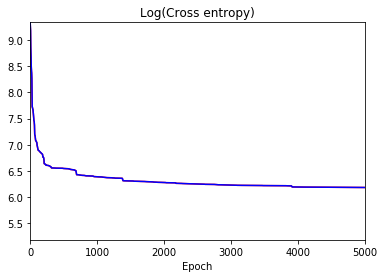

test results written to: imagery/AST_20070501_pca_NNet(Congrad).tst
done


In [2]:
run scripts/classify -p [1,2,3,4] -a 4 -e 5000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

In [3]:
run scripts/classify -p [1,2,3,4] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

Training with MaxLike
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.00247001647949
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 1.77681779861
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_MaxLike.tst
done


In [4]:
run scripts/mcnemar imagery/AST_20070501_pca_NNet(Congrad).tst imagery/AST_20070501_pca_MaxLike.tst

     McNemar test
first classifier:
NNet(Congrad)test results for imagery/AST_20070501_pca.tif
Wed Aug 15 09:50:02 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

second classifier:
MaxLiketest results for imagery/AST_20070501_pca.tif
Wed Aug 15 09:50:45 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

test observbations: 2364
classes: 10
first classifier: 87
second classifier: 128
McNemar statistic: 7.818605
P-value: 0.005171


In [5]:
run scripts/classify -p [1,2,3,4] -a 7 imagery/AST_20070501_pca.tif imagery/train.shp

Training with SVM
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.45729804039
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 48.7534911633
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_SVM.tst
done


In [7]:
run scripts/mcnemar imagery/AST_20070501_pca_NNet(Congrad).tst imagery/AST_20070501_pca_SVM.tst

     McNemar test
first classifier:
NNet(Congrad)test results for imagery/AST_20070501_pca.tif
Wed Aug 15 09:50:02 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

second classifier:
SVMtest results for imagery/AST_20070501_pca.tif
Wed Aug 15 09:56:00 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

test observbations: 2364
classes: 10
first classifier: 89
second classifier: 103
McNemar statistic: 1.020833
P-value: 0.312321


In [8]:
run scripts/classify -p [1,2,3,4] -a 6 -e 5000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 80.2147250175
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 10.4438140392
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


In [9]:
run scripts/mcnemar imagery/AST_20070501_pca_NNet(Congrad).tst imagery/AST_20070501_pca_Dnn(tensorflow).tst

     McNemar test
first classifier:
NNet(Congrad)test results for imagery/AST_20070501_pca.tif
Wed Aug 15 09:50:02 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

second classifier:
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif
Wed Aug 15 10:03:16 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

test observbations: 2364
classes: 10
first classifier: 85
second classifier: 102
McNemar statistic: 1.545455
P-value: 0.213808


## Adaptive boosting

Training with ADABOOST.M1 and 3 epochs per ffn
reading training data...
running instance: 1  trial: 1
train error: 0.022926 test error: 0.021151
running instance: 2  trial: 1
train error: 0.017924 test error: 0.018190
running instance: 3  trial: 1
train error: 0.014798 test error: 0.016074
running instance: 4  trial: 1
train error: 0.015632 test error: 0.016074
running instance: 5  trial: 1
train error: 0.014381 test error: 0.015228
running instance: 6  trial: 1
train error: 0.014589 test error: 0.015228
running instance: 7  trial: 1
train error: 0.013130 test error: 0.016497
running instance: 8  trial: 1
train error: 0.013130 test error: 0.016497
running instance: 9  trial: 1
train error: 0.012922 test error: 0.016497
running instance: 10  trial: 1
train error: 0.012922 test error: 0.016497
running instance: 11  trial: 1
train error: 0.012714 test error: 0.016920
running instance: 12  trial: 1
train error: 0.012714 test error: 0.016920
running instance: 13  trial: 1
train error: 0.012

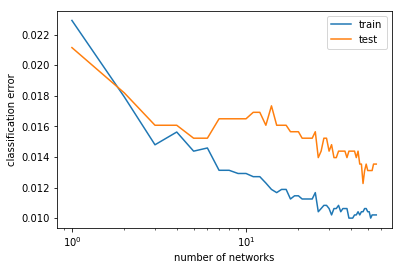

classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
thematic map written to: imagery/AST_20070501_pca_class.tif
elapsed time 17.6629190445


In [2]:
run scripts/adaboost -p [1,2,3,4,5,6]  -L [10] -n 75 imagery/AST_20070501_pca.tif  imagery/train.shp

In [2]:
ls imagery

AST_20010409
AST_20010409.hdr
AST_20010730
AST_20010730.hdr
AST_20050911
AST_20050911.hdr
AST_20070501*
AST_20070501.hdr*
AST_20070501_pca_classprobs_plr.tif
AST_20070501_pca_classprobs.tif
AST_20070501_pca_class.tif
AST_20070501_pca_Dnn(tensorflow).tst
AST_20070501_pca_MaxLike.tst
AST_20070501_pca_NNet(Congrad).tst
AST_20070501_pca_SVM.tst
AST_20070501_pca.tfw*
AST_20070501_pca.tif*
AST_3N
AST_3N.hdr
ASTaspect.tif
AST_DEM
AST_DEM.hdr
ASTslope.tif
IKON_ms
IKON_ms.hdr
IKON_ms_pan_atwt
IKON_ms_pan_atwt.hdr
IKON_ms_pan_dwt
IKON_ms_pan_dwt.hdr
IKON_pan
IKON_pan.hdr
LE7_20010525*
LE7_20010525.hdr*
LE7_20010626*
LE7_20010626.aux.xml
LE7_20010626_canny
LE7_20010626_canny.hdr
LE7_20010626_corner
LE7_20010626_corner.hdr
LE7_20010626.hdr*
LE7_20010829
LE7_20010829.hdr
LT5_19980329.tif
LT5_19980516.tif
S1A_IW_SLC__1SDV_20141108T054351_20141108T054421_003186_003AB4_B367.tif
S1A_IW_SLC__1SDV_20141202T054350_20141202T054420_003536_004299_33DA.tif
S1A_IW_SLC__1SDV_20150131T054348_20150131T054418_0044

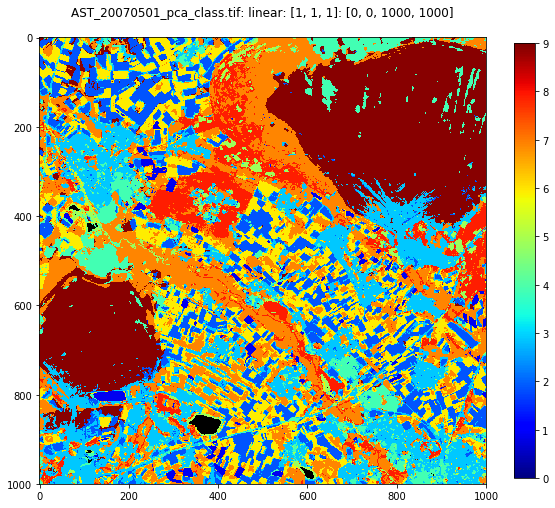

In [3]:
run scripts/dispms -f /home/mort/python/CRC4Docker/src/imagery/AST_20070501_pca_class.tif -c

## Hyperspectral image analysis

In [2]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
import matplotlib.pyplot as plt

inDataset = gdal.Open('myimagery/97_radianz_registriert_voll',GA_ReadOnly)                       
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
print rows, cols, bands

512 614 224


In [3]:
Im = np.zeros((rows,cols,bands)) 
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    Im[:,:,b] = band.ReadAsArray(0,0,cols,rows)  

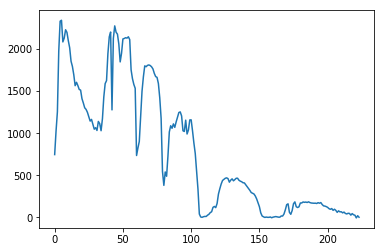

In [4]:
# spectral cut
plt.plot(Im[300,300,:])

------------MNF ---------------
Sat Aug 18 10:53:56 2018
Input myimagery/97_radianz_registriert_voll
Signal to noise ratios: [5.310017   4.7277856  2.9155533  2.5726933  2.3541558  2.1224613
 2.0613933  1.933816   1.9143653  1.7802563  1.7069731  1.6836028
 1.5607548  1.4374497  1.3844261  1.3522758  1.2939186  1.2733986
 1.1041543  1.0854423  1.0046413  0.98647666 0.9436563  0.7977916
 0.74426174 0.6855979  0.6366588  0.6056988  0.58014894 0.56575656
 0.5399685  0.52157307 0.49738097 0.47191775 0.46629143 0.44623995
 0.43123126 0.40730333 0.3995031  0.38853216 0.37567365 0.3736484
 0.36823845 0.36341262 0.36158073 0.34864676 0.34585297 0.34333324
 0.34205437 0.34014225 0.33844423 0.33651996 0.3359301  0.33468044
 0.33320582 0.33197355 0.33139956 0.33047163 0.32929146 0.3275119
 0.32583845 0.32520103 0.32355964 0.3229401  0.32182956 0.3194071
 0.31894588 0.31779182 0.31641865 0.31605434 0.3144635  0.31380403
 0.3133397  0.31125045 0.31034827 0.31020045 0.3087411  0.30728042
 0.3063209 

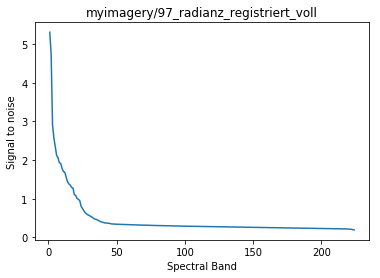

MNFs written to: myimagery/97_radianz_registriert_voll_mnf
elapsed time: 13.4630138874


<Figure size 432x288 with 0 Axes>

In [5]:
run scripts/mnf.py myimagery/97_radianz_registriert_voll

### Anomaly detection

In [8]:
run scripts/rx imagery/may0107

------------ RX ---------------
Sun May 13 16:49:58 2018
Input imagery/may0107
Result written to imagery/may0107_rx
elapsed time: 0.410514116287


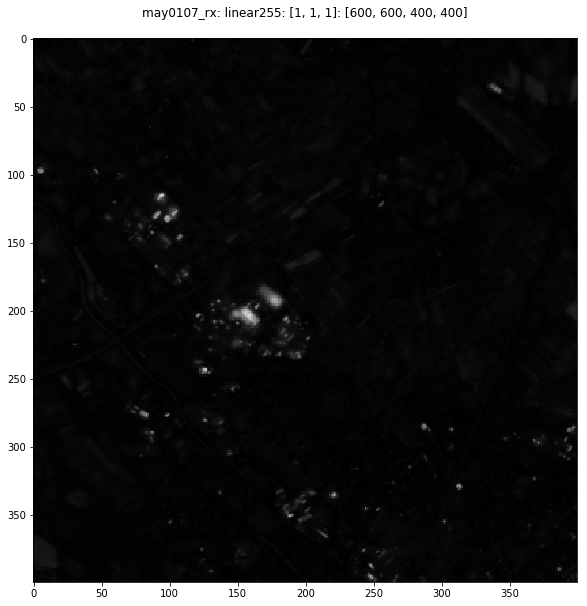

In [27]:
run scripts/dispms -f imagery/may0107_rx -e 1 -d [600,600,400,400]

In [17]:
run scripts/krx -s 2000 imagery/may0107

------------ KRX ---------------
Sun May 13 16:59:41 2018
Input imagery/may0107
GMA: 0.000003
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
Result written to imagery/may0107_krx
elapsed time: 199.017396927


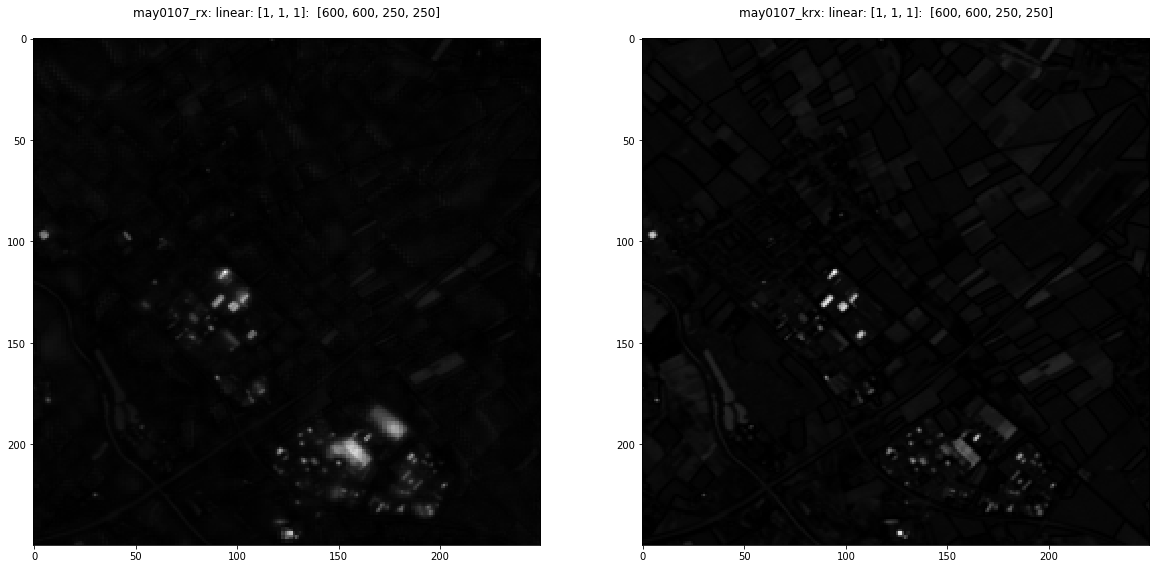

In [2]:
run scripts/dispms -f imagery/may0107_rx -e 2 -d [600,600,250,250] \
-F imagery/may0107_krx -E 2 -D [600,600,250,250] \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_8.eps'